<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Оценка-лучшей-модели" data-toc-modified-id="Оценка-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оценка лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# основные библиотеки
import pandas as pd
import re
import numpy as np
import time
import torch
import transformers
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

from tqdm import notebook

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package wordnet to /home/danila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/danila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/danila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')
else:
    print('File not found')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**Вывод:** Датасет загрузился корректно. Всего в датасете 159 292 строки.

In [6]:
# дубликаты отсутствуют
data.duplicated().sum()

0

In [7]:
# удаляем лишний столбец
data = data.drop('Unnamed: 0', axis = 1)

In [8]:
# заранее очистим текст
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    #приводим к нижнему регистру
    text = text.lower()
    
    # удаляем пробелы 
    text = " ".join(text.split())
    
    #лемматизируем
    text = nltk.word_tokenize(text)
    text = ' '.join([WordNetLemmatizer().lemmatize(x) for x in text])
    
    return text

In [10]:
%%time
data['text'] = data['text'].apply(lambda x: clear_text(x))

CPU times: user 1min, sys: 54.7 ms, total: 1min
Wall time: 1min


In [11]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestion on impro...,0
4,you sir are my hero any chance you remember wh...,0


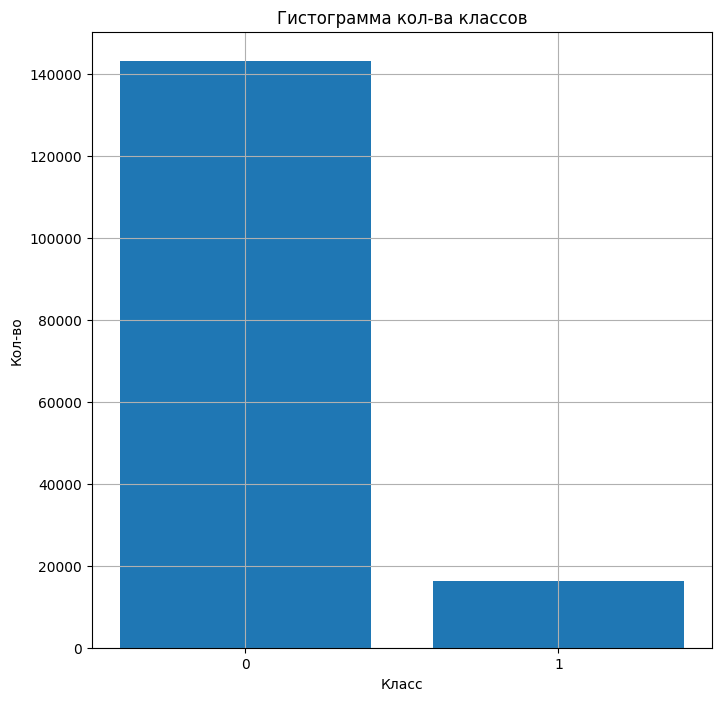

In [12]:
plt.figure(figsize = (8,8))
plt.bar(x = ['0', '1'], height = data['toxic'].value_counts())
plt.title('Гистограмма кол-ва классов')
plt.xlabel('Класс')
plt.ylabel('Кол-во')
plt.grid(True)

In [13]:
# сохраним данные для разных моделей
data_tf_idf = data.copy()
data_bert = data.copy()
data_Word2Vec = data.copy()

In [14]:
# Подготовка выборки для TfidfVectorizer

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_tf_idf['text'], data_tf_idf['toxic'],
                                                    random_state = 12345, test_size = 0.35)

In [16]:
X_train.shape, X_test.shape

((103539,), (55753,))

In [17]:
data['text'].memory_usage(deep=True)

67564237

In [18]:
# corpus_train = X_train.values.astype('U')
# corpus_test = X_test.values.astype('U')

In [19]:
stopwords = set(nltk_stopwords.words('english'))

In [20]:
%%time
try:
    count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))
except:
    count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf_train = count_tf_idf.fit_transform(X_train) 
tf_idf_test = count_tf_idf.transform(X_test) 


CPU times: user 6.04 s, sys: 31.9 ms, total: 6.07 s
Wall time: 6.07 s


In [21]:
tf_idf_train.shape, tf_idf_test.shape

((103539, 122367), (55753, 122367))

**Вывод:** Датасет состоит из 159292 строк. Текст из строк был очищен от символов, разделен на датасеты для обучения моделей. В исходном датасете присутствует сильный дисбаланс классов. Тренировочный датасет состоит из 103539. Для моделей sklearn была произведена токенизация, кол-во токенов составило 130904 столбца, что сильно ограничевает обучения моделей из за черезмерного потребления ресурсов памяти локального ПК.

## Обучение

In [23]:
def fit_model_RS( model, param_grid, n_jobs = -1 ):
    '''Перебор параметров моделей'''
    
    #Шаги пайплайна
    steps = [
    ('pca', PCA()),
    ('model', model)]
    
    # Pipeline
    pipeline = Pipeline(steps)
    
    # подбор гиперпараметров
    RS_model = RandomizedSearchCV(
        model,
        param_grid,
        scoring = 'f1',
        random_state = 12345,
        n_jobs = n_jobs,
        cv = 3
    )
    
    start = time.time()
    
    # фит модели
    RS_model.fit(tf_idf_train, y_train)
    
    end = time.time()
    
    
    # лучшие параметры
    try:
        print('fbest_params:', {RS_model.best_params_})
    except:
        print('fbest_params:', dict(RS_model.best_params_))
    else:
        pass
    
    print(f'Время выполнения подбора параметров = {(end - start) / 60} мин.')
    
    return RS_model


In [24]:
def best_thr(model, X_train, y_train):

    '''Проверка изменение метрики при манипуляции с вероятностями классов'''
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                    random_state = 12345, test_size = 0.35)
    
    BestThr = -1
    Bestf1 = -1

    f1 = []

    model_to_prob = model.fit(X_train, y_train)
    
    pred_proba = model_to_prob.predict_proba(X_valid)

    # перебор вероятности и поиск лучшей метрики f1
    for thr in np.arange(0, 1, 0.01):

        classes = (pred_proba[:, 1] >= thr)*1
        f_1 = f1_score(y_valid, classes)
        f1.append(f_1)

        if f_1 > Bestf1:
            Bestf1 = f_1
            BestThr = thr


    print (f'Лучшая оценка f1 на valid = {Bestf1} получается при вероятности класс 1 равному {BestThr}')
    print (f'Оценка f1 на valid = {f1_score(y_valid, model.predict(X_valid))} ') 
    
    return BestThr
    

In [25]:
%%time
# LogisticRegression

lr_model  =  LogisticRegression(random_state = 12345)

# комбинаций гиперпараметров
param_grid = dict(
    penalty = ['l1', 'l2'],
    class_weight = ['balanced', None],
    solver = ['lbfgs', 'liblinear', 'saga'],
    C = [1.0, 2.0, 3.0]
    )

lr_RS = fit_model_RS(lr_model, param_grid)


/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

fbest_params: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 3.0}
Время выполнения подбора параметров = 1.1908870577812194 мин.
CPU times: user 1.18 s, sys: 129 ms, total: 1.31 s
Wall time: 1min 11s


In [26]:
%%time
BestThr = best_thr(lr_RS, tf_idf_train, y_train)

/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Лучшая оценка f1 на valid = 0.7790393013100436 получается при вероятности класс 1 равному 0.38
Оценка f1 на valid = 0.7690900777320531 
CPU times: user 1.73 s, sys: 64.3 ms, total: 1.79 s
Wall time: 38.2 s


In [27]:
%%time

# LGBMClassifier перегружен кол-вом стоблцов и имеет черезмерное время обучения даже на базовой модели
# (без перебора параметров) пока отложил в долгий ящик

# LGBMClassifier

# gb_model  =  LGBMClassifier(random_state = 12345)

# # комбинаций гиперпараметров
# param_grid = dict(
#     learning_rate = [0.1, 0.05],
#     n_estimators = [100, 200],
#     max_depth = [-1],
#     class_weight = ['balanced', None],
#     )

# gb_RS = fit_model_RS(gb_model, param_grid)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [28]:
# BestThr = best_thr(gb_RS, tf_idf_test)

# pred_proba = gb_RS.predict_proba(tf_idf_test)
# pred = gb_RS.predict(tf_idf_test)

# classes = (pred_proba[:, 1] >= BestThr) * 1

# print('f1 best (LGBMClassifier) = ', f1_score(y_test, pred))
# print('f1 best correct proba (LGBMClassifier) = ', f1_score(y_test, classes))

In [29]:
%%time
# не хватает памяти для перебора параметров, потребность выходит за 50 гигов оперативки, пока обучаю на базовой

cb_RS  = CatBoostClassifier(random_state = 42, task_type = "GPU")
cb_RS.fit(tf_idf_train, y_train)

Learning rate set to 0.026118
0:	learn: 0.6642180	total: 219ms	remaining: 3m 38s
1:	learn: 0.6378238	total: 398ms	remaining: 3m 18s
2:	learn: 0.6131180	total: 561ms	remaining: 3m 6s
3:	learn: 0.5900726	total: 738ms	remaining: 3m 3s
4:	learn: 0.5684798	total: 900ms	remaining: 2m 59s
5:	learn: 0.5483450	total: 1.06s	remaining: 2m 56s
6:	learn: 0.5301201	total: 1.23s	remaining: 2m 55s
7:	learn: 0.5123903	total: 1.41s	remaining: 2m 55s
8:	learn: 0.4964270	total: 1.58s	remaining: 2m 53s
9:	learn: 0.4811477	total: 1.74s	remaining: 2m 52s
10:	learn: 0.4662828	total: 1.94s	remaining: 2m 54s
11:	learn: 0.4528539	total: 2.11s	remaining: 2m 54s
12:	learn: 0.4392660	total: 2.32s	remaining: 2m 56s
13:	learn: 0.4270939	total: 2.51s	remaining: 2m 56s
14:	learn: 0.4154089	total: 2.7s	remaining: 2m 57s
15:	learn: 0.4051780	total: 2.87s	remaining: 2m 56s
16:	learn: 0.3952176	total: 3.05s	remaining: 2m 56s
17:	learn: 0.3858503	total: 3.26s	remaining: 2m 58s
18:	learn: 0.3769313	total: 3.46s	remaining: 2m

In [30]:
# %%time
# # CatBoostClassifier

# cb_model  =  CatBoostClassifier()

# # комбинаций гиперпараметров
# param_grid = dict(
#     learning_rate = [0.1, 0.05],
#     task_type = ["GPU"],
#     random_state = [42]
#     )

# cb_RS = fit_model_RS(cb_model, param_grid)

In [31]:
BestThr = best_thr(cb_RS, tf_idf_train, y_train)

Learning rate set to 0.026744
0:	learn: 0.6645512	total: 128ms	remaining: 2m 8s
1:	learn: 0.6377898	total: 250ms	remaining: 2m 4s
2:	learn: 0.6128893	total: 370ms	remaining: 2m 2s
3:	learn: 0.5896605	total: 506ms	remaining: 2m 5s
4:	learn: 0.5677848	total: 622ms	remaining: 2m 3s
5:	learn: 0.5479169	total: 731ms	remaining: 2m 1s
6:	learn: 0.5295068	total: 843ms	remaining: 1m 59s
7:	learn: 0.5117026	total: 989ms	remaining: 2m 2s
8:	learn: 0.4955841	total: 1.12s	remaining: 2m 3s
9:	learn: 0.4805387	total: 1.24s	remaining: 2m 2s
10:	learn: 0.4654016	total: 1.41s	remaining: 2m 6s
11:	learn: 0.4523614	total: 1.54s	remaining: 2m 7s
12:	learn: 0.4386863	total: 1.69s	remaining: 2m 8s
13:	learn: 0.4268619	total: 1.8s	remaining: 2m 6s
14:	learn: 0.4148284	total: 1.95s	remaining: 2m 8s
15:	learn: 0.4046920	total: 2.08s	remaining: 2m 7s
16:	learn: 0.3950973	total: 2.18s	remaining: 2m 6s
17:	learn: 0.3860713	total: 2.32s	remaining: 2m 6s
18:	learn: 0.3768973	total: 2.48s	remaining: 2m 7s
19:	learn: 

In [32]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
model = transformers.BertModel.from_pretrained("bert-base-uncased")

In [33]:
# ограничение выборки
data_short_bert = data_bert.sample( n = 1000, replace = True)

In [34]:
%%time
# перевод текста в токены 

tokenized = data_short_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.22 s


In [35]:
# создания тензоров для обучения
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.Tensor(attention_mask[batch_size*i : batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].numpy())



  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
# создание датасета из тензоров и  деление выборки

features = np.concatenate(embeddings)
target = data_short_bert['toxic']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 12345)


In [37]:
# без перебора указал лучшие фичи для прошлой линейной модели
lr = LogisticRegression(solver = 'saga', penalty = 'l1', class_weight = None, random_state = 12345)
lr.fit(X_train, y_train)

predict = lr.predict(X_test)

print(f1_score(y_test,predict))

0.5517241379310346


**Вывод:** Была подобрана лучшая модель на данный момент - LogisticRegression, так же модель, которая обучалась на токинах BERT показала интересный результат, несмотря на то что модель состояла выборки равной 1000 строк. 

In [38]:
# !pip install FastText

In [39]:
import fasttext

In [40]:
# Разделяем на трейн, валидацию и тест
train, test = train_test_split(data_Word2Vec, test_size = 0.25)
train, valid = train_test_split(train, test_size = 0.35)


In [41]:
train.shape, valid.shape, test.shape

((77654, 2), (41815, 2), (39823, 2))

In [42]:
# Производить загрузку данных в модель будем через текстовые фалики

with open('train.txt', 'w') as f:
    for each_text, each_label in zip(train['text'], train['toxic']):
        f.writelines(f'__label__{each_label} {each_text}\n')

with open('valid.txt', 'w') as f:
    for each_text, each_label in zip(valid['text'], valid['toxic']):
        f.writelines(f'__label__{each_label} {each_text}\n')

with open('test.txt', 'w') as f:
    for each_text, each_label in zip(test['text'], test['toxic']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [43]:
#проверка на корректность загрузки данных в файл
!head -n 5 train.txt

__label__1 i will net left harassing you i am the same ip s whom you re blocking i will gon na destroy you
__label__0 such a the edit you made to richard machowicz
__label__1 baby eater alright is it true that some of the band s song translate into lyric like i m going to cut open your fetus and eat your baby or other horrific lyric
__label__0 i ve edited the page accordingly
__label__1 hello you recently yipped and yapped about me breaking the rule but i notice that your latest update you edited in a proud faggot nutsack within my userpage i find this intolerable bigoted and downright hateful perhaps homosexual african american elecit anger in you you should visit www adl org


In [44]:
def print_results(sample_size, precision, recall):
    '''Функция для тестирования натренировонной модели'''
    
    precision = round(precision, 5)
    recall = round(recall, 5)
    
    print(f'{sample_size = }')
    print(f'{precision = }')
    print(f'{recall = }')
    print(f'f1_score = {(2*(precision*recall))/(precision+recall)}')

In [45]:
# Просмотр на корректность работы модели
model = fasttext.train_supervised('train.txt')
print_results(*model.test('valid.txt'))

Read 5M words
Number of words:  103927
Number of labels: 2
Progress: 100.0% words/sec/thread: 3624922 lr:  0.000000 avg.loss:  0.111298 ETA:   0h 0m 0s


sample_size = 41815
precision = 0.9608
recall = 0.9608
f1_score = 0.9608


In [46]:
# Посмотрим как работает модель с указанием каких-либо параметров
model = fasttext.train_supervised('train.txt', epoch=10, lr=1.0, wordNgrams = 2)
print_results(*model.test('valid.txt'))

Read 5M words
Number of words:  103927
Number of labels: 2
Progress: 100.0% words/sec/thread: 1811767 lr:  0.000000 avg.loss:  0.042789 ETA:   0h 0m 0s


sample_size = 41815
precision = 0.95884
recall = 0.95884
f1_score = 0.95884


In [47]:
# Воспользуемся строенным в библиотеку автоподблром гиперпараметров
model = fasttext.train_supervised('train.txt', autotuneValidationFile='valid.txt', autotuneMetric="f1:__label__1")
print_results(*model.test('valid.txt'))

Progress: 100.0% Trials:   13 Best score:  0.787887 ETA:   0h 0m 0s
Training again with best arguments
Read 5M words
Number of words:  103927
Number of labels: 2
Progress: 100.0% words/sec/thread: 4118954 lr:  0.000000 avg.loss:  0.112785 ETA:   0h 0m 0s


sample_size = 41815
precision = 0.96078
recall = 0.96078
f1_score = 0.96078


## Оценка лучшей модели

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data_tf_idf['text'], data_tf_idf['toxic'],
                                                    random_state = 12345, test_size = 0.35)

In [51]:
%%time

# Лучшая модель ML-classic

BestThr = best_thr(lr_RS, tf_idf_train, y_train)

pred_proba = lr_RS.predict_proba(tf_idf_test)
pred = lr_RS.predict(tf_idf_test)

classes = (pred_proba[:, 1] >=  BestThr) * 1

print('f1 test data(LogisticRegression) = ', f1_score(y_test, pred))
print('f1 correct proba test data(LogisticRegression) = ', f1_score(y_test, classes))

/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/danila/mainpk/jupyter/jupyter_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Лучшая оценка f1 на valid = 0.7790393013100436 получается при вероятности класс 1 равному 0.38
Оценка f1 на valid = 0.7690900777320531 
f1 test data(LogisticRegression) =  0.7753792298716452
f1 correct proba test data(LogisticRegression) =  0.7794472268595808
CPU times: user 1.82 s, sys: 629 ms, total: 2.45 s
Wall time: 43 s


In [52]:
# Лучшая модель из предтренерованных моделей
# fasttext
print_results(*model.test('test.txt'))


sample_size = 39823
precision = 0.9614
recall = 0.9614
f1_score = 0.9614


## Выводы

>В ходе работы были выполнены следующие операции:

>>Предобработаны данные для обучения
>
>>Исследованы различные модели обучения.
>
>>Выбрана лучшая модель.


>В ходе исследования была подобрана лучшая модель классичесткого ML - LogisticRegression, метрика f1 на тестовой выборке составила 0.779 c учетом калиборвки вероятностей класса 1. Ввиду огромной выборки, обучения на всех данных не представляется возможным, необходимо сокращать датафрейм. Градиентные бустинги показали неудволетворительынй результат ввиду ресурсных ограничений, т.к. данные методы очень затраты по памяти. В модели BERT можно увидеть потенциал, но данный метод аналогично ограничен по времени и памяти (в первую очереть память).
Из предобученных готовых моделей лучшей оказалась модель fasttext, метрика f1 на ней составила 0.96. В данном случае это самый лучший результат из всех исследованных моделей.